# Marketing Analytics
# AB Test

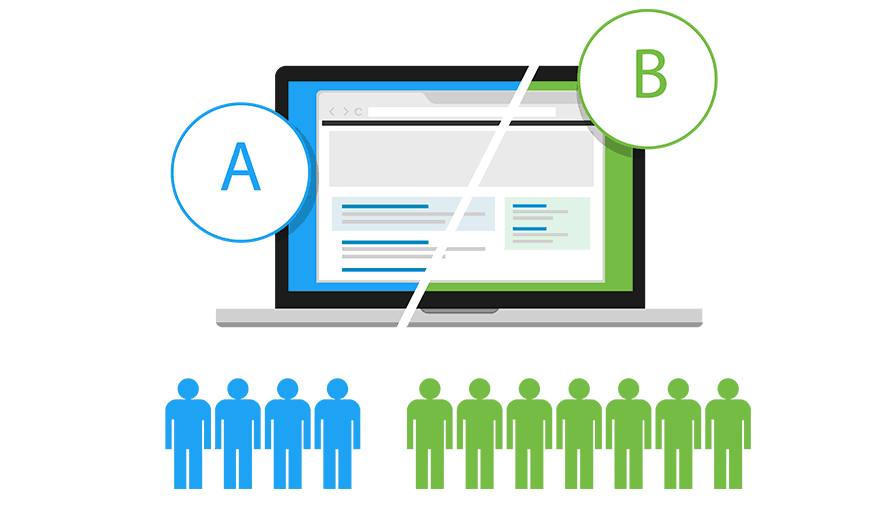

In this analysis, we will cover the process of evaluating an A/B experiment, including formulating a hypothesis, conducting the test, and interpreting the results. For our data, we will use a dataset from Kaggle that includes the results of an A/B test on two different website page designs (old_page vs. new_page).

[Dataset Source](https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv)


## Importing and loading the libraries

In [361]:
# Imports
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from datetime import datetime

# Formating the graphics
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

## Loading the Dataset

In [364]:
df = pd.read_csv("ab_data.csv")

In [365]:
df.sample(5)

,user_id,timestamp,group,landing_page,converted
168146,832786,2017-01-24 05:41:04.311304,control,old_page,0
30784,807227,2017-01-14 12:11:37.581176,treatment,new_page,0
53841,775284,2017-01-13 07:38:20.724938,treatment,new_page,0
157574,689364,2017-01-08 05:17:51.200023,control,old_page,0
33352,754680,2017-01-05 19:55:24.562874,treatment,new_page,0


## Exploratory Analysis

In [366]:
df.shape

(294478, 5)

In [367]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [368]:
# end date of the data collect
dMax = df['timestamp'].max()[0:10]
print(dMax)

2017-01-24


In [369]:
# start date
dMin = df['timestamp'].min()[0:10]
print(dMin)

2017-01-02


In [370]:
#Time diff
days = datetime.strptime(dMax, "%Y-%m-%d")-datetime.strptime(dMin, "%Y-%m-%d")
print(days)

22 days, 0:00:00


In [371]:
# Checking null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [372]:
# Proportion of conversion result
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [373]:
# Proportion of variants shown to users
df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [374]:
df.landing_page.value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

In [375]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [376]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


There are, in fact, 3894 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice.

In [377]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [378]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


### Calculating basic probabilities.

**Label A means Control group. 
Label B means Test or Treatment.**

In [379]:
# Probability that a user will view the control variant
df[df.group == 'control'].shape[0] / df.shape[0] * 100

49.98186194146988

In [380]:
# Probability that a user will view the treatment variant
df[df.group == 'treatment'].shape[0] / df.shape[0] * 100

50.01813805853011

In [381]:
# Total users who bought the product during this user session
df.converted.sum()

34245

In [382]:
# Total users who bought the product during this user session in control group
df[df.group == 'control'].converted.sum()

17220

In [383]:
# Total users who bought the product during this user session in treatment group
df[df.group == 'treatment'].converted.sum()

17025

In [384]:
#Conversion Rate
df.converted.mean()

0.11944957968537445

In [385]:
#Conversion rate of control group
df[df.group == 'control'].converted.mean()

0.12017335110577627

In [386]:
#Conversion rate of treatment group?
df[df.group == 'treatment'].converted.mean()

0.11872633318688676

## Setting up the Experiment

To provide an analysis of an A/B-test, let assume, that the conversion in our company was 12%. We would like to increase this number to 14%. Therefore, we created A/B-test to ensure that a new version of a site will certainly increase the conversion.

Does the new page increase the conversion rate?

Label A: The users will be shown the old design

Label B: The users will be shown the new design

We want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct.

Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a two-tailed test:

- H0: PB - PA = 0
- H1: PB - PA > 0

H0 tells us that the probability difference of the two groups is equal to zero.

H0 tells us that the probability difference of the two groups more than zero.

where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%: 0.05

### Data Preprocessing


In [387]:
df_ab = df[['group', 'converted']]

In [388]:
new_dict = {"control": "A",
           "treatment": "B"}

In [389]:
df_ab["group"]=df_ab['group'].map(new_dict)

C:\Users\arthu\AppData\Local\Temp\ipykernel_15248\1919302219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ab["group"]=df_ab['group'].map(new_dict)


In [390]:
df_ab.head()

,group,converted
0,A,0
1,A,0
2,B,0
3,B,0
4,A,1


## Hypothesis Test

To decide what number of people we need to prove/reject the hypothesis, we have to conduct a power analysis.

Power of the test or sensitivity.

Same than 1 - $\beta$. 

Usually 80% is used for most analyses. It is the probability of rejecting the null hypothesis when the null hypothesis is in fact false.

Parameters that we will use to run the test:

1- Alfa (Significance Level) $\alpha$: Normally 5%; Probability of reject the null hypothesis when the null hypothesis is true

2- Beta $\beta$: Probability of accept the null hypotesis when the null hypotesis is false

In [391]:
alfa = 0.05
beta = 0.2

In [398]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates (12% for current rate and 14% to the expected rate)

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1)                                                  # Calculating sample size needed         

print(round(required_n))

4432


We’d need at least **4432** observations for each group.

In [404]:
# Sample size
n_sample = round(required_n)

In [405]:
df_A = df_ab[df_ab['group'] == 'A'].sample(n=n_sample, random_state=100)
df_B = df_ab[df_ab['group'] == 'B'].sample(n=n_sample, random_state=100)

In [407]:
df_ab = pd.concat([df_A,df_B], axis=0)
df_ab.shape

(8864, 2)

In [408]:
df_ab['group'].value_counts()

B    4432
A    4432
Name: group, dtype: int64

In [410]:
# Pivot table for the data summary
df_ab_summary = df_ab.pivot_table(values = 'converted', index = 'group', aggfunc = np.sum)

In [411]:
# Visualiza os dados
df_ab_summary.head()

,converted
group,
A,531
B,492


In [412]:
# Sumário com total 
df_ab_summary['total'] = df_ab.pivot_table(values = 'converted', index = 'group', aggfunc = lambda x: len(x))

In [413]:
# Sumário com taxa
df_ab_summary['rate'] = df_ab.pivot_table(values = 'converted', index = 'group')

In [414]:
# Visualiza os dados
df_ab_summary.head()

,converted,total,rate
group,,,
A,531,4432,0.119810
B,492,4432,0.111011


At first group B did not show any improvement in terms of conversion rate

In [415]:
# We get the values of variant A
convert_A = df_ab_summary['converted'][0]
total_A = df_ab_summary['total'][0]
rate_A = df_ab_summary['rate'][0]

In [417]:
print(convert_A)
print(total_A)
print(rate_A)

531
4432
0.11981046931407942


In [418]:
# We get the values of variant B
convert_B = df_ab_summary['converted'][1]
total_B = df_ab_summary['total'][1]
rate_B = df_ab_summary['rate'][1]

In [419]:
print(convert_B)
print(total_B)
print(rate_B)

492
4432
0.11101083032490974


In [420]:
# Baseline conversion rate.
convert_base = rate_A
convert_base

0.11981046931407942

Minimum Detectable Effect.

Sometimes referred to as the level of practical significance.

In [422]:
# Minimum Detectable Effect.
min_effect = rate_B - rate_A
min_effect

-0.008799638989169675

We can assume that the distribution of our control group is binomial because the data is a series of Bernoulli trials, where each trial has only two possible outcomes (similar to a coin toss).
 
 For the test we will use SciPy's binom() function:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html

In [423]:
# Binomial Test (using 5% standard for the significance level)
test_binom = scs.binom(n, p = convert_base)

In [424]:
# Binomial test with minimum effect
test_binom_mde = scs.binom(n, p = convert_base + min_effect)

We now visualize a probabilistic mass function (pmf).

C:\Users\arthu\anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 4433 artists>

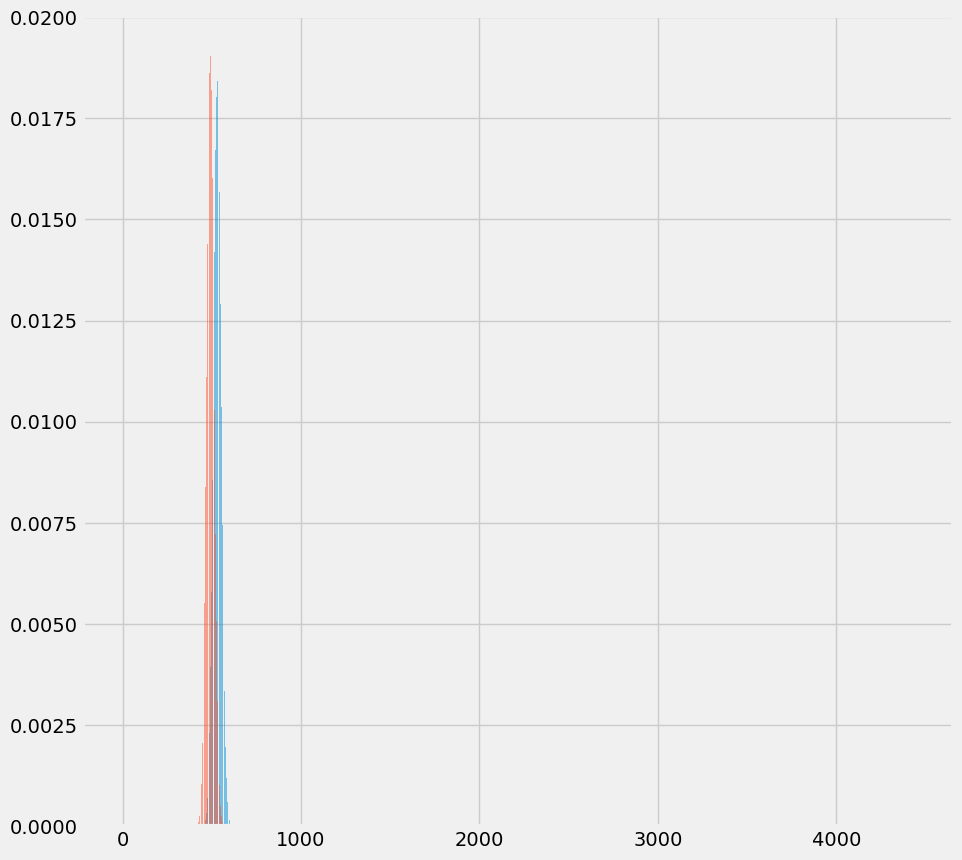

In [425]:
# Plot

# Plot area
fig, ax = plt.subplots(figsize = (10, 10))

# setting X
x = np.linspace(0,int(n), int(n) + 1)

# Ploting the results of pmf and alfa 0.5
ax.bar(x, test_binom.pmf(x), alpha = 0.5)
ax.bar(x, test_binom_mde.pmf(x), alpha = 0.5)

## Distribution Plot

We create the Plot of the distribution of the difference between the two samples and compare the results.

We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result of our test group.

Text(0, 0.5, 'Probability')

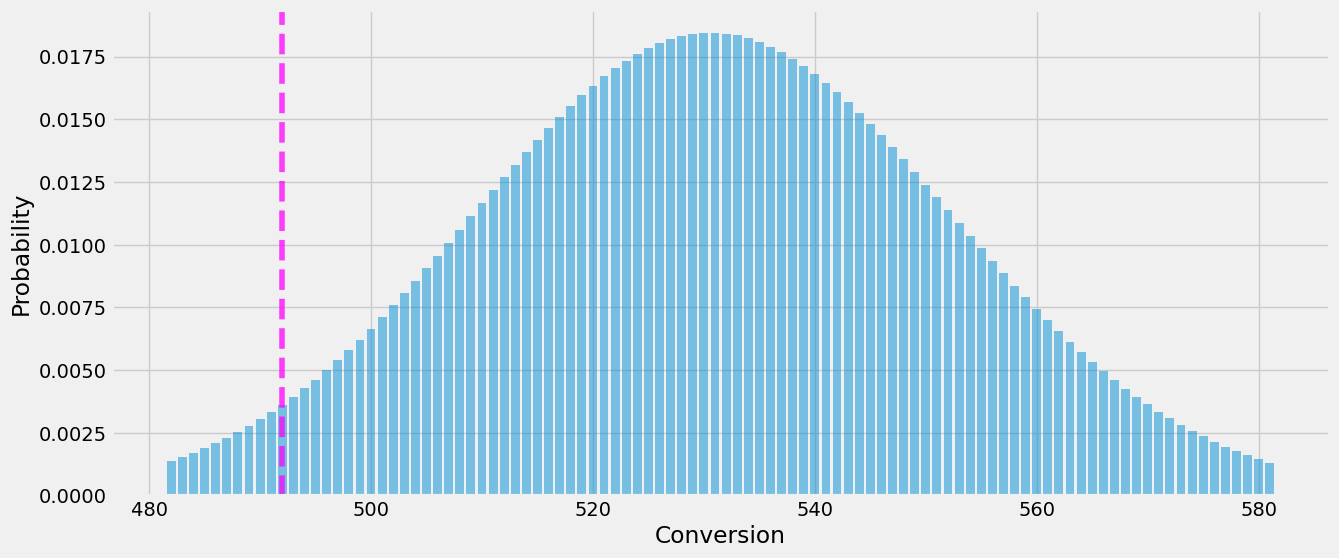

In [428]:
# Plot of group A distribution (control)

# Plot area
fig, ax = plt.subplots(figsize = (14,6))

# Test of A
x = np.linspace(convert_A - 49, convert_A + 50, 100)
y = scs.binom(total_A, rate_A).pmf(x)

#Creates the vertical bar
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = rate_B * total_A, c = 'magenta', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')

Text(0, 0.5, 'Probability')

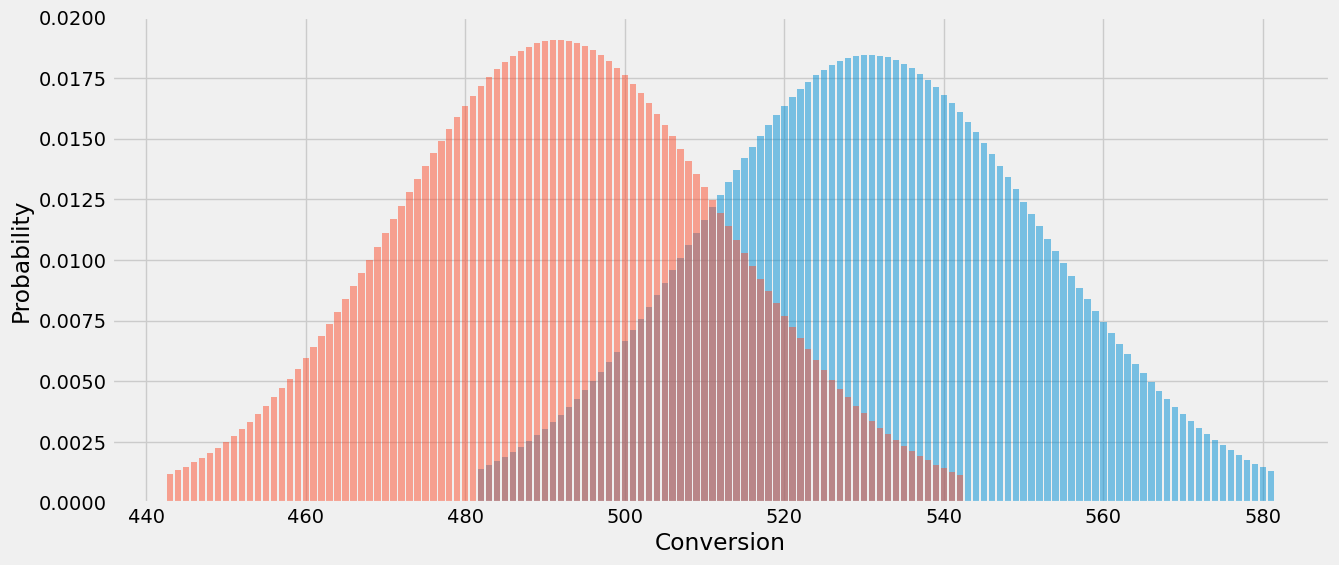

In [482]:
# Plot of the distribution of the 2 groups

# Plot area
fig, ax = plt.subplots(figsize = (14,6))

# Graphic of A
xA = np.linspace(convert_A - 49, convert_A + 50, 100)
yA = scs.binom(total_A, rate_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Graphic of B
xB = np.linspace(convert_B - 49, convert_B + 50, 100)
yB = scs.binom(total_B, rate_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')

We can see that the treatment group converted fewer users than the control group.

In [430]:
# Odds (conversion rates)
p_A = rate_A
p_B = rate_B

# Number of conversions
N_A = 531
N_B = 492

In [483]:
# Standard error for the mean of both groups
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

In [484]:
# Print
print(SE_A)
print(SE_B)

0.0048779304983707795
0.004718794175815496


Text(0, 0.5, 'PDF - Probability Density Function')

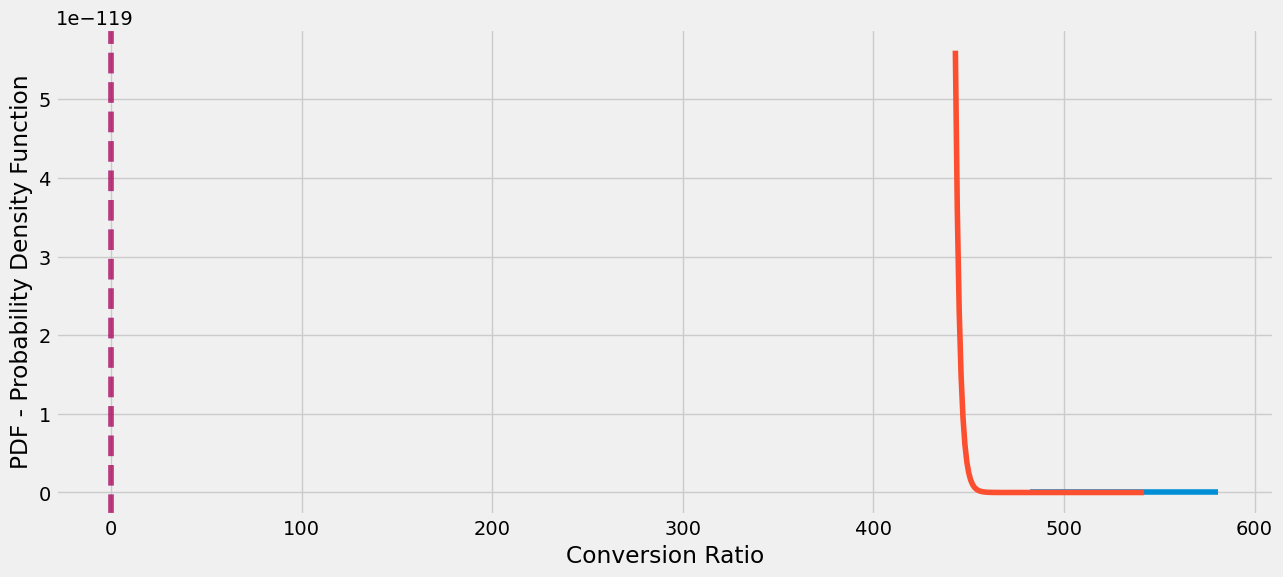

In [486]:
# Plot of the distributions of the null and alternative hypotheses

# Plot Area
fig, ax = plt.subplots(figsize = (14,6))

# Data for the random variable
x = np.linspace(0, p_B - p_A, 100)

# Distribution of A
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x = p_A, c = 'blue', alpha = 0.5, linestyle = '--')

# Distribution of B
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x = p_B, c = 'red', alpha = 0.5, linestyle = '--')

# Labels
plt.xlabel('Conversion Ratio')
plt.ylabel('PDF - Probability Density Function')

The continuous lines represent the average conversion rate for each group. The distance between the blue line and the red line is equal to the average difference between the control and test group. 

### Checking the Null Hypothesis and the Alternative Hypothesis

Let's start by recalling the definition of the null hypothesis and the alternative hypothesis.

**The null hypothesis is the position that the design change made to the test group would result in no change in the conversion rate.**

**The alternative hypothesis is the opposite position that the change in design made to the test group would result in an improvement (or reduction) in the conversion rate.**

The null hypothesis will be a normal distribution with a mean of zero and a standard deviation equal to the pooled standard error.

Formula for the calculation of z:

$$ z = \frac{(\bar{x_1}-\bar{x_2})-D_0}{\sqrt{\sigma_1^{2}/n_1+\sigma_{2}^{2}/n_2}} $$

$$ z = \frac{(\hat{p_1}-\hat{p_2})-0}{\sqrt{\hat{p}\hat{q}(\frac{1}{n_1}+\frac{1}{n_2})}}$$

In [487]:
nobs = [total_A, total_B]
successes = [convert_A, convert_B]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.30
p-value: 0.195
95% Confidence interval for control group: [0.110, 0.129]
95% Confidence interval for treatment group: [0.102, 0.120]


## Conclusion

Based on our p-value of 0.195, which is much higher than our alpha of 0.05, we cannot reject the null hypothesis that the new design did not perform significantly differently than the old design. This suggests that the new design may not have performed better than the old one.

Additionally, if we look at the confidence interval for the treatment group ([0.102, 0.120], or 10.2-12.0%) we notice that: The conversion rate of the new design is more likely to be around 12%, which is our baseline value, rather than the 14% target we were hoping for. This indicates that the new design is not likely to be an improvement over the old design, and we will have to return to the drawing board.

Therefore, this new version of the site is unlikely to significantly increase conversion. Based on the results of the A/B test, it does not make sense for the company to introduce this new version of the site.